# Import

In [585]:
from PIL import Image
import matplotlib.pyplot as plt
import cv2
import tight_subplot as ts
import nonmax as nm
import numpy as np
import scipy as sp
import math

# Problem 1: Image Pyramids

Load the provided image “texture.jpeg” and convert it to grayscale. Write code for a Gaussian and Laplacian pyramid of 5 levels (use for loops). At each level, the resolution should be reduced by a factor of 2. Show your pyramids and include the code in your submission.

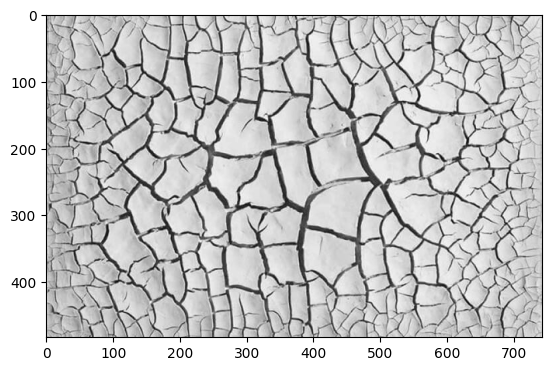

In [586]:
# Convert to gray scale
texture_img = cv2.imread('texture.jpeg')
texture_img_yuv = cv2.cvtColor(texture_img, cv2.COLOR_BGR2YUV)
texture_y, texture_u, texture_v = cv2.split(texture_img_yuv)
# display the Y component
plt.imshow(texture_y, cmap='gray')
Y, X, Z = texture_img.shape
texture_img_gray = np.float32(texture_y)
# texture_img_gray = np.dot(texture_img[...,:3], [0.2989, 0.587, 0.114])
# Y, X = texture_img_gray.shape
# print(texture_img_gray.shape)

## Part 1: 
Display a Gaussian and Laplacian pyramid of level 5 (write your code). It should be formatted
similarly to Figure 1 above. You may find the included “tight_subplot.py” helpful for making plots.

In [587]:
def scale_image(image, desired_width, desired_height):
    return cv2.resize(image, (desired_width, desired_height), interpolation=cv2.INTER_LINEAR)

In [588]:
def get_filter(kernel_size, sigma):
    kernel = cv2.getGaussianKernel(kernel_size, sigma)
    image_filter = np.dot(kernel, kernel.T)
    return image_filter

In [589]:
def getGaussianPyramid(image, image_filter, iterations):
    gaussian_images = []
    original_image = image
    for i in range(iterations):
        blurred_image = cv2.filter2D(original_image, -1, image_filter)
        gaussian_images.append(blurred_image)
        # original_image = blurred_image[::2, ::2].copy()
        original_image = scale_image(blurred_image, blurred_image.shape[1]//2, blurred_image.shape[0]//2)
    return gaussian_images

In [590]:
def getLaplacianPyramid(image, image_filter, iterations):
    laplacian_images = []
    original_image = image
    for i in range(iterations):
        blurred_image = cv2.filter2D(original_image, -1, image_filter)
        # compute residual
        residual = np.subtract(original_image, blurred_image)
        laplacian_images.append(residual)

        # original_image = blurred_image[::2, ::2].copy()
        original_image = scale_image(blurred_image, blurred_image.shape[1]//2, blurred_image.shape[0]//2)
    return laplacian_images

In [591]:
# this method will pad the image with white space when making it bigger
def resizeImage(image, width, height):

    # get the max value in image
    max_value = np.max(image)

    # Create a white image with the desired size
    resized_image = np.ones((height, width)) * max_value

    # Get the dimensions of the original image
    original_height, original_width = image.shape

    # Place the original image onto the new image
    resized_image[0:original_height, 0:original_width] = image

    return resized_image


In [592]:
gaussian_pyramid, laplacian_pyramid = getGaussianPyramid(texture_img_gray, get_filter(5, 1), 5), getLaplacianPyramid(texture_img_gray, get_filter(5, 1), 5)

In [593]:
resized_gaussian_pyramid = [resizeImage(image, X, Y) for image in gaussian_pyramid]
resized_laplacian_pyramid = [resizeImage(image, X, Y) for image in laplacian_pyramid]

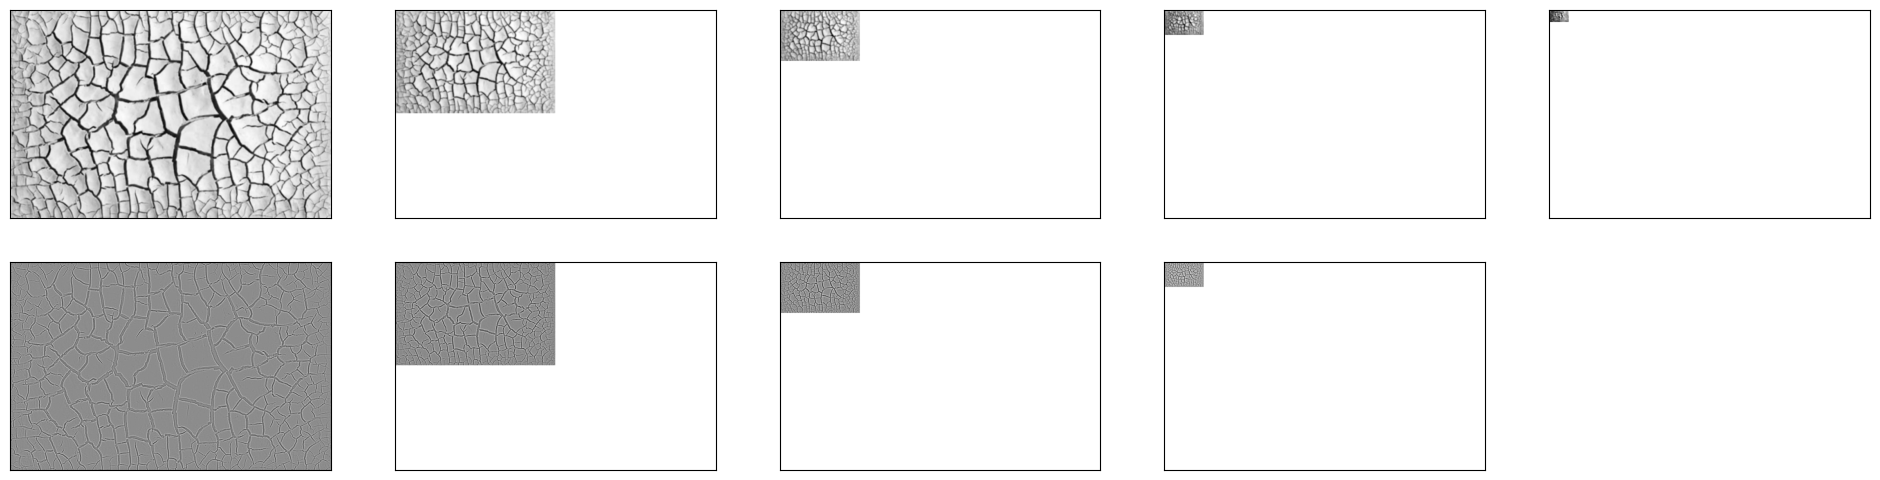

In [594]:
ts.tight_subplot_2x5(resized_gaussian_pyramid, resized_laplacian_pyramid[:len(resized_gaussian_pyramid) - 1])

## Part 2: 
Display the FFT amplitudes of your Gaussian/Laplacian pyramids. Appropriate display ranges ("vmin", "vmax") should be chosen so that frequencies in different pyramid levels are clearly visible. Explain what the Laplacian and Gaussian pyramids are doing in terms of frequency.

In [596]:
def scale_image(image, desired_width, desired_height):
    return cv2.resize(image, (desired_width, desired_height), interpolation=cv2.INTER_LINEAR)

In [609]:
def get_fft(gaussian_pyramid, laplacian_pyramid, iterations):
    fft_gaussian_images = []
    fft_laplacian_images = []
    for i in range(iterations):
        fft_gaussian_image = np.fft.fft2(gaussian_pyramid[i])
        fft_shift_gaussian_image = np.fft.fftshift(fft_gaussian_image)
        magnitude_spectrum_gaussian = 20 * np.log(np.abs(fft_shift_gaussian_image))
        fft_gaussian_images.append(magnitude_spectrum_gaussian)

        fft_laplacian_image = np.fft.fft2(laplacian_pyramid[i])
        fft_shift_laplacian_image = np.fft.fftshift(fft_laplacian_image)
        magnitude_spectrum_laplacian = 20 * np.log(np.abs(fft_shift_laplacian_image))
        fft_laplacian_images.append(magnitude_spectrum_laplacian)
    
    return fft_gaussian_images, fft_laplacian_images


In [610]:
fft_gaussian_images, fft_laplacian_images = get_fft(gaussian_pyramid, laplacian_pyramid, 5)

In [611]:
scaled_fft_gaussian_images = [scale_image(image, X, Y) for image in fft_gaussian_images]
scaled_fft_laplacian_images = [scale_image(image, X, Y) for image in fft_laplacian_images]

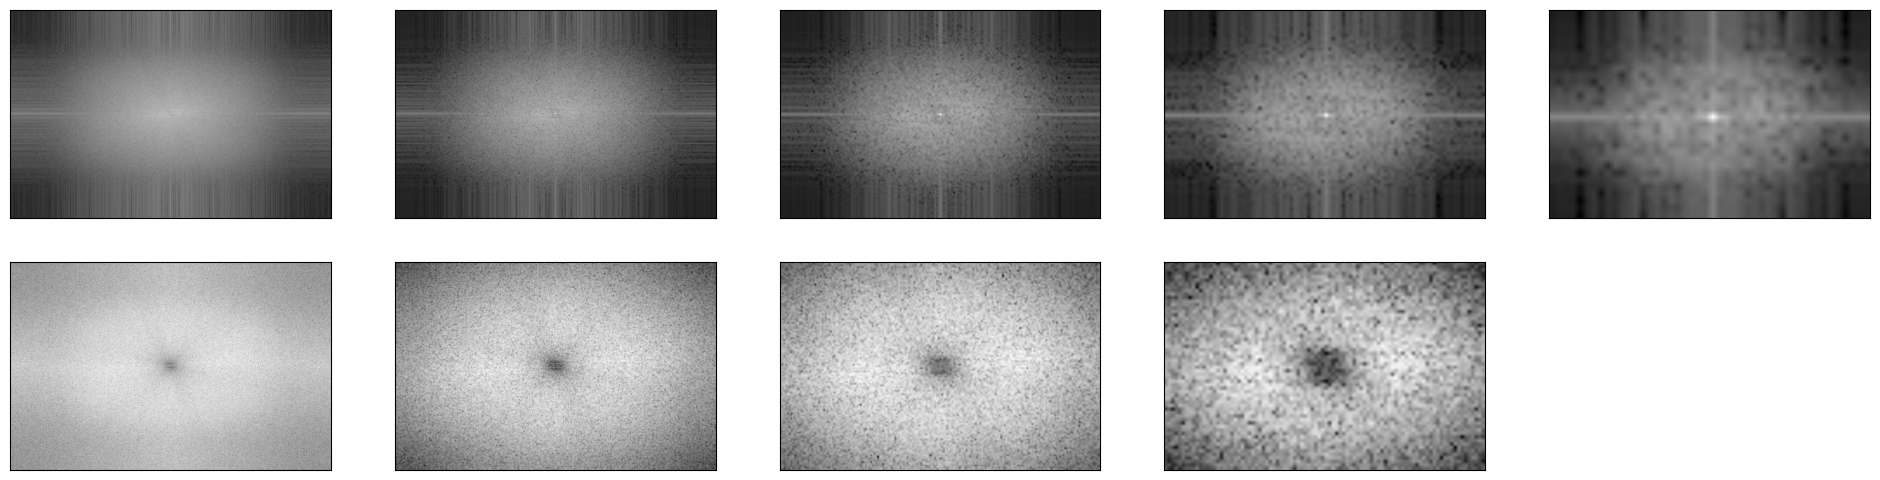

In [612]:
ts.tight_subplot_2x5(scaled_fft_gaussian_images, scaled_fft_laplacian_images[:len(scaled_fft_gaussian_images) - 1])

# Problem 2: Edge Detection

In this problem, we will detect the edges of the provided image "plane.jpg".

## Part 1: Build a simple gradient-based edge detector that includes the following functions
Complete two functions below, and visualize your detected edges.


1. `def gradientMagnitude(im: np.ndarray, sigma: float): return mag: np.ndarray, theta: np.ndarray`

This function should take an RGB image as input, smooth the image with a Gaussian filter (std=sigma),
compute the x and y gradient values of the smoothed image, and output image maps of the gradient
magnitude and orientation at each pixel. You can compute the gradient magnitude of an RGB image by
taking the L2-norm of the R, G, and B gradients. The orientation can be computed from the channel
corresponding to the largest gradient magnitude. The overall gradient magnitude is the L2-norm of the x
and y gradients. mag and theta should be the same size as im.

2. `def edgeGradient(im: np.ndarray): return bmap: np.ndarray`

This function should use gradientMagnitude to compute a soft boundary map and then perform
non-maxima suppression. You could use the provided nonmax.py.

Useful functions include: cv2.getGaussianKernel, cv2.filter2D, cv2.spatialGradient, np.take_along_axis

In [627]:
def gradientMagnitude(im: np.ndarray, sigma: float):
    # return mag: np.ndarray, theta: np.ndarray
    # img is a RGB image
    # compute the gradients x and y gradients for each R, G, and B

    # smooth image first
    im = cv2.GaussianBlur(im, (5, 5), sigma)
    
    red_channel = im[:, :, 0]
    green_channel = im[:, :, 1]
    blue_channel = im[:, :, 2]

    red_channel = np.float32(red_channel)
    green_channel = np.float32(green_channel)
    blue_channel = np.float32(blue_channel)

    # red_channel = cv2.GaussianBlur(red_channel, (3, 3), sigma)
    # green_channel = cv2.GaussianBlur(green_channel, (3, 3), sigma)
    # blue_channel = cv2.GaussianBlur(blue_channel, (3, 3), sigma)


    # Method 1
    sobel_x = np.array([[1, 0, -1], [2, 0, -2], [1, 0, -1]])
    sobel_y = sobel_x.T

    red_x_gradient = cv2.filter2D(red_channel, -1, sobel_x)
    red_y_gradient = cv2.filter2D(red_channel, -1, sobel_y)

    green_x_gradient = cv2.filter2D(green_channel, -1, sobel_x)
    green_y_gradient = cv2.filter2D(green_channel, -1, sobel_y)

    blue_x_gradient = cv2.filter2D(blue_channel, -1, sobel_x)
    blue_y_gradient = cv2.filter2D(blue_channel, -1, sobel_y)


    # Method 2
    # red_x_gradient = cv2.Sobel(red_channel, ddepth=cv2.CV_32F, dx=1, dy=0, ksize=3)
    # red_y_gradient = cv2.Sobel(red_channel, ddepth=cv2.CV_32F, dx=0, dy=1, ksize=3)

    # green_x_gradient = cv2.Sobel(green_channel, ddepth=cv2.CV_32F, dx=1, dy=0, ksize=3)
    # green_y_gradient = cv2.Sobel(green_channel, ddepth=cv2.CV_32F, dx=0, dy=1, ksize=3)

    # blue_x_gradient = cv2.Sobel(blue_channel, ddepth=cv2.CV_32F, dx=1, dy=0, ksize=3)
    # blue_y_gradient = cv2.Sobel(blue_channel, ddepth=cv2.CV_32F, dx=0, dy=1, ksize=3)

    
    # Method 3
    # red_x_gradient, red_y_gradient = cv2.spatialGradient(red_channel, dx=1, dy=1)
    # green_x_gradient, green_y_gradient = cv2.spatialGradient(green_channel, dx=1, dy=1)
    # blue_x_gradient, blue_y_gradient = cv2.spatialGradient(blue_channel, dx=1, dy=1)

    # compute the gradient magnitude and direction
    
    red_magnitude = np.sqrt(np.square(red_x_gradient) + np.square(red_y_gradient))
    green_magnitude = np.sqrt(np.square(green_x_gradient) + np.square(green_y_gradient))
    blue_magnitude = np.sqrt(np.square(blue_x_gradient) + np.square(blue_y_gradient))

    magnitude = np.sqrt(np.square(red_magnitude) + np.square(green_magnitude) + np.square(blue_magnitude))

    # theta = np.arctan2(red_y_gradient + green_y_gradient + blue_y_gradient, red_x_gradient + green_x_gradient + blue_x_gradient)

    red_theta = np.arctan2(red_y_gradient, red_x_gradient)
    green_theta = np.arctan2(green_y_gradient, green_x_gradient)
    blue_theta = np.arctan2(blue_y_gradient, blue_x_gradient)

    theta_array = np.array([red_theta, green_theta, blue_theta])
    magnitude_array = np.array([red_magnitude, green_magnitude, blue_magnitude])
    max_magnitude_index = np.argmax(magnitude_array, axis=0)

    theta = np.take_along_axis(theta_array, max_magnitude_index[None, ...], axis=0)[0]

    return magnitude, theta

In [628]:
def edgeGradient(im: np.ndarray):
    # return bmap: np.ndarray
    magnitude, theta = gradientMagnitude(im, 1)
    non_maxima_suppressed_edge = nm.non_max_suppression(magnitude, theta)
    return non_maxima_suppressed_edge

(321, 481, 3)


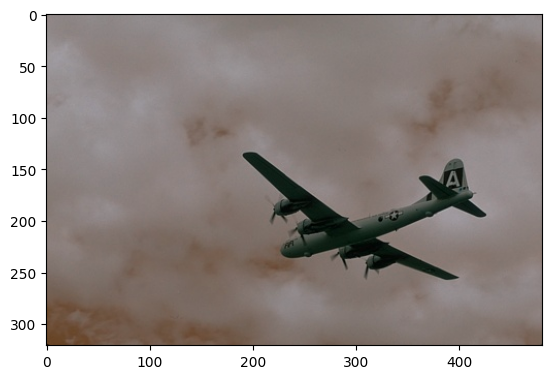

In [629]:
# Test Code
# img = Image.open('plane.jpg')
img = cv2.imread('plane.jpg', cv2.IMREAD_COLOR)
print(img.shape)
plt.imshow(img)

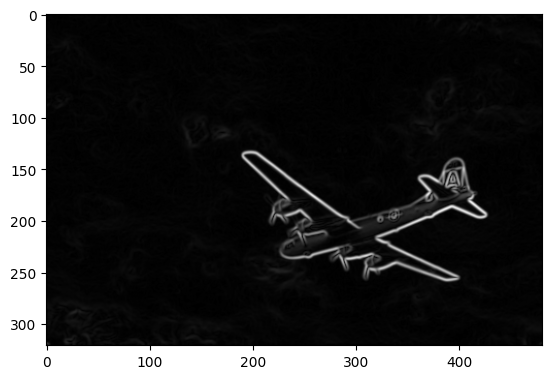

In [630]:
magnitude, theta = gradientMagnitude(img, 1)
plt.imshow(magnitude, cmap='gray')

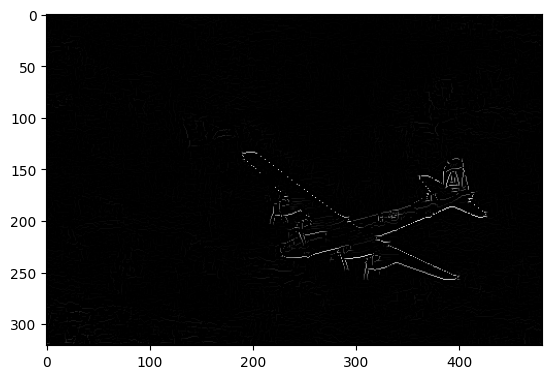

In [631]:
thin_edge = edgeGradient(img)
plt.imshow(thin_edge, cmap='gray')

## Part 2: Try to improve your results using a set of oriented filters, rather than the simple derivative of Gaussian approach above, including the following functions

Complete two functions below, and visualize both filters you used and your detected edges.

1. `def orientedFilterMagnitude(im: np.ndarray): return mag: np.ndarray, theta: np.ndarray`

Computes the boundary magnitude and orientation using a set of oriented filters, such as elongated
Gaussian derivative filters. Explain your choice of filters. Use at least four orientations. One way to combine filter responses is to compute a boundary score for each filter (simply by filtering with it) and then use the max and argmax over filter responses to compute the magnitude and orientation for each pixel.

2. `def edgeOrientedFilters(im: np.ndarray): return bmap: np.ndarray`

Similar to Problem 2.1, this should call orientedFilterMagnitude, perform the non-maxima suppression, and output the final soft edge map.

Useful functions include: np.mgrid, scipy.stats.multivariate_normal

In [663]:
def orientedFilterMagnitude(im: np.ndarray, filter_type_dist: bool = True):
    # return mag: np.ndarray, theta: np.ndarray
    # orientations would be 0, 45, 90, 135 degrees
    
    def getOrientedFilterUsingCombination(degree):
        # Using https://medium.com/@itberrios6/a-quick-introduction-to-steerable-filters-3fd8813f2e63 as reference
        # Get Sobel Kernels

        Gx = np.array([[1, 0, -1],  
                    [2, 0, -2],
                    [1, 0, -1]])     # 0 Degrees
        Gy = Gx.T                       # 90 degrees

        # Perform Sobel Combination
        degree = degree + np.pi/2
        G_theta = np.cos(degree)*Gx + np.sin(degree)*Gy
        
        return G_theta

    def getOrientedFilterUsingDistribution(degree, sigma):

        degree = degree + np.pi/2

        # generate the coordinates
        x,y = np.mgrid[-1:2, -1:2]

        # rotate the coordinates
        x_rot = x * np.cos(degree) - y * np.sin(degree)
        y_rot = x * np.sin(degree) + y * np.cos(degree)

        # create the kernel
        kernel = np.zeros((3, 3))

        # create the multivariate normal distribution
        mvn = sp.stats.multivariate_normal([0, 0], [[sigma**2, 0], [0, sigma**2]])

        # sample the distribution at each coordinate
        kernel = -x_rot * mvn.pdf(np.stack([x_rot, y_rot], axis=-1))

        # normalize the kernel
        kernel /= np.sum(np.abs(kernel))

        return kernel

    sigma = 1
    im = cv2.GaussianBlur(im, (5, 5), sigma)
    # im = cv2.normalize(im, None, 0, 1, cv2.NORM_MINMAX, dtype=cv2.CV_32FC1) // this makes it worse, but for the previous part, this made it better, ASK
    
    num_rows = len(im)
    num_cols = len(im[0])
    red_channel = im[:, :, 0]
    green_channel = im[:, :, 1]
    blue_channel = im[:, :, 2]

    red_channel = np.float32(red_channel)
    green_channel = np.float32(green_channel)
    blue_channel = np.float32(blue_channel)

    orientations = [0, np.pi/6, np.pi/2, 5*np.pi/6]
    red_mags = []
    blue_mags = []
    green_mags = []
    magnitude_array = []
    
    final_mags = np.ones((num_rows, num_cols))

    filter_set = []
    
    for orientation in orientations:
        # a kernel size of 3x3 was assumed

        orientation = -1 * orientation
        
        filter_comb = getOrientedFilterUsingCombination(orientation)
        filter_dist = getOrientedFilterUsingDistribution(orientation, sigma=1)

        filter = filter_dist if filter_type_dist else filter_comb

        # apply the filter
        red_mags.append(cv2.filter2D(red_channel, -1, filter))
        green_mags.append(cv2.filter2D(green_channel, -1, filter))
        blue_mags.append(cv2.filter2D(blue_channel, -1, filter))
        magnitude = np.sqrt(np.square(red_mags[-1]) + np.square(green_mags[-1]) + np.square(blue_mags[-1]))
        magnitude_array.append(magnitude)

        filter_set.append(filter)

    magnitude_array = np.array(magnitude_array)
    max_magnitude_index = np.argmax(magnitude_array, axis=0)
    final_mags = np.take_along_axis(magnitude_array, max_magnitude_index[None, ...], axis=0)[0]
    final_thetas = np.array(orientations)[max_magnitude_index]

    return final_mags, final_thetas, filter_set

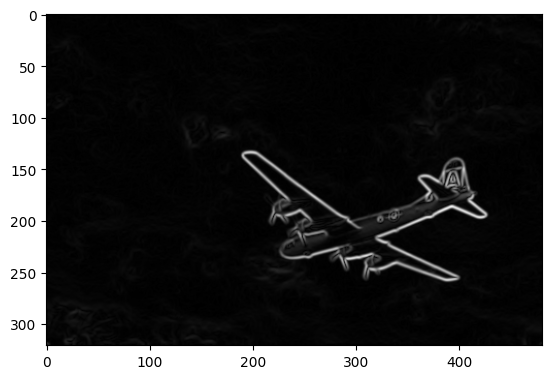

In [664]:
# Test Code
img = Image.open('plane.jpg')
img = np.array(img)
mag, theta, filters = orientedFilterMagnitude(img, filter_type_dist=True)
plt.imshow(mag, cmap='gray')

In [665]:
def edgeOrientedFilters(im: np.ndarray, filter_type_dist: bool = True):
    # return bmap: np.ndarray
    magnitude, theta, _ = orientedFilterMagnitude(img, filter_type_dist)
    non_maxima_suppressed_edge = nm.non_max_suppression(magnitude, theta)
    return non_maxima_suppressed_edge

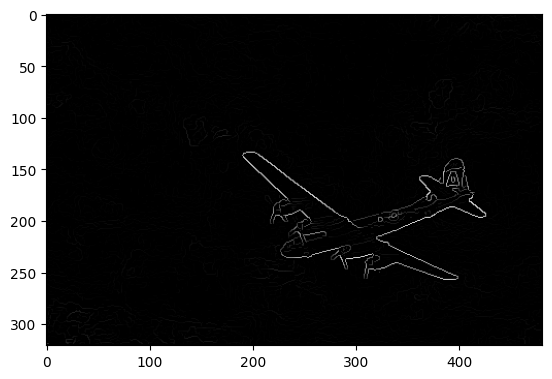

In [666]:
thin_edge = edgeOrientedFilters(img, True)
plt.imshow(thin_edge, cmap='gray')

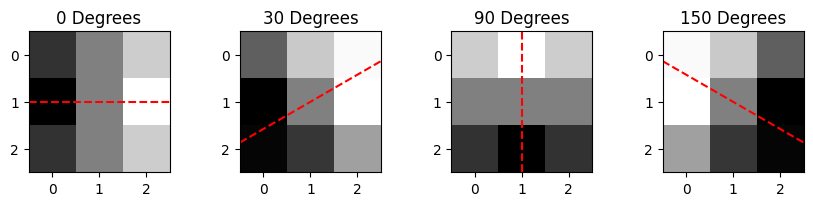

In [667]:
figure, axis = plt.subplots(1, 4, figsize=(10, 10), )
plt.subplots_adjust(wspace=0.5, hspace=0.5)

degrees = [0, 30, 90, 150]
for idx, degree in enumerate(degrees):
    axis[idx].imshow(filters[idx], cmap='gray')
    axis[idx].set_title(f'{degree} Degrees')

    if degree != 90:
        # Convert the angle to radians
        angle_radians = np.deg2rad(degree)

        # Calculate the slope of the line
        slope = -np.tan(angle_radians)  # Negate the slope here

        # Calculate the center of the matrix
        x_center = filters[idx].shape[1] // 2
        y_center = filters[idx].shape[0] // 2

        # Calculate the y-intercept of the line passing through the center
        y_intercept = y_center - slope * x_center

        # Generate x values for the line
        x_values = np.linspace(-0.5, filters[idx].shape[1] - 0.5, (filters[idx].shape[1] * 2) + 1)

        # Calculate y values for the line
        y_values = slope * (x_values - x_center) + y_center

        # Plot the line
        axis[idx].plot(x_values, y_values, '--', color='red')
    else:
        x_center = filters[idx].shape[1] // 2
        axis[idx].axvline(x=x_center, color='red', linestyle='--')

